# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



- An analysis/description of which questions are most crucial concerning their placement on the axes.

step 1 - cleaning and grouping the questions

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
plt.rcParams['image.cmap'] = "gray"

In [7]:
import pandas as pd

# Load the data
TV2Questions_clean = pd.read_excel("tv2q.xlsx")
# Remove the 'depends' column
columns_to_drop =['depends','type']
TV2Questions_clean = TV2Questions_clean.drop(columns=columns_to_drop)

TV2Questions_clean = TV2Questions_clean[~TV2Questions_clean['header'].str.contains('Storkreds', case=False)]
TV2Questions_clean.reset_index(drop=True, inplace=True)
TV2Questions_clean

,id,header,question
0,1a,Miljø og klima,"Oksekød bør pålægges en klimaafgift, således a..."
1,1b,Miljø og klima,"De virksomheder, der udleder mest CO₂, skal be..."
2,2a,Hospitaler og sundhed,Folketinget bør afsætte midler målrettet et lø...
3,2b,Hospitaler og sundhed,Cigaretter bør pålægges en ekstra afgift på 20...
4,3a,Udenrigs- og forsvarspolitik,Danmark bør bruge to procent af BNP på forsvar...
5,3b,Udenrigs- og forsvarspolitik,Ulandsbistanden bør hæves.
6,4a,Økonomi,Den økonomiske ulighed i det danske samfund bø...
7,4b,Økonomi,Staten bør i højere grad kompensere danskerne ...
8,5a,Ældre,Det er nødvendigt at indføre brugerbetaling i ...
9,5b,Ældre,Der bør tilføres ekstra ressourcer til ældrepl...


In [8]:
DRQuestions_clean = pd.read_excel('drq.xlsx')
DRQuestions_clean = DRQuestions_clean[['ID', 'Title', 'Question']]
DRQuestions_clean

,ID,Title,Question
0,530,KLIMA OG ENERGI,Danmark skal bruge flere penge på at styrke to...
1,531,ARBEJDSMARKED OG ØKONOMI,Der skal indføres en særlig skat på de allerhø...
2,533,RET OG STRAF,Kriminalitet begået i udsatte boligområder ska...
3,534,EU OG UDENRIGS,På sigt skal Danmark meldes ud af EU
4,535,EU OG UDENRIGS,"Det er fornuftigt, at Danmark i de kommende år..."
5,537,VELFÆRD,"Det er okay, at den økonomiske ulighed stiger,..."
6,538,UDDANNELSE,Forældres indkomst skal være et af kriterierne...
7,540,VELFÆRD,Det skal være muligt at tjene penge på at driv...
8,541,ARBEJDSMARKED OG ØKONOMI,Der skal indføres skat på fortjenesten ved sal...
9,543,VELFÆRD,"Det er en god idé, at dagpengesatsen for nyudd..."


In [9]:
import pandas as pd
allData = pd.read_excel("alldata.xlsx")
columns_to_drop = ['storkreds', 'alder', 'parti', 'navn']
questions_data = allData.drop(columns_to_drop, axis=1)
questions_data.columns = questions_data.columns.astype(str)
questions_data


,530,531,533,534,535,537,538,540,541,543,...,8a,8b,9a,9b,10a,10b,11a,11b,12a,12b
0,-1,-2,1,-2,2,1,-2,1,1,2,...,1,0,2,0,1,-2,-2,1,1,1
1,2,2,-1,-2,-1,-2,1,-2,2,-2,...,0,0,-2,0,-1,2,1,-2,0,0
2,2,1,-2,-2,1,-2,1,-1,1,-1,...,1,1,-1,-2,0,2,0,-1,1,-2
3,2,1,-2,-1,1,1,1,1,1,-2,...,2,2,-2,2,2,2,2,-1,2,0
4,1,1,-2,2,-2,1,-2,1,2,-2,...,1,0,-2,0,-1,0,-2,0,2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,1,1,1,-2,2,-1,1,-2,1,1,...,2,1,1,2,-1,2,1,-2,0,0
863,1,-2,-2,-2,1,-2,-1,-2,-2,-2,...,1,0,-1,0,-1,2,2,-2,0,0
864,1,1,1,-2,2,-1,1,-1,-1,1,...,1,0,-1,0,-1,2,2,-2,0,1
865,1,-1,1,-2,1,-1,-1,-1,-1,1,...,0,0,0,0,0,2,1,-2,1,0


In [10]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(questions_data)
X_scaled = scaler.transform(questions_data)


using diff scaler maybe? since this one will only get 41% of the variance

In [11]:
from sklearn import (datasets, decomposition, ensemble, 
                     metrics, model_selection, preprocessing)
from sklearn.decomposition import PCA

X= questions_data 
print(X)
X_s = preprocessing.StandardScaler().fit_transform(X)
pca4 = decomposition.PCA(n_components=None)
res4 = pca4.fit_transform(X_s)
pca4.explained_variance_ratio_

     530  531  533  534  535  537  538  540  541  543  ...  8a  8b  9a  9b  \
0     -1   -2    1   -2    2    1   -2    1    1    2  ...   1   0   2   0   
1      2    2   -1   -2   -1   -2    1   -2    2   -2  ...   0   0  -2   0   
2      2    1   -2   -2    1   -2    1   -1    1   -1  ...   1   1  -1  -2   
3      2    1   -2   -1    1    1    1    1    1   -2  ...   2   2  -2   2   
4      1    1   -2    2   -2    1   -2    1    2   -2  ...   1   0  -2   0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..  ..  ..   
862    1    1    1   -2    2   -1    1   -2    1    1  ...   2   1   1   2   
863    1   -2   -2   -2    1   -2   -1   -2   -2   -2  ...   1   0  -1   0   
864    1    1    1   -2    2   -1    1   -1   -1    1  ...   1   0  -1   0   
865    1   -1    1   -2    1   -1   -1   -1   -1    1  ...   0   0   0   0   
866    1    1   -1   -2    1   -1    1   -1    1   -1  ...   1   1  -2  -1   

     10a  10b  11a  11b  12a  12b  
0      1   -2   -2    1    

array([0.41737636, 0.10259865, 0.04976015, 0.04300927, 0.0293233 ,
       0.0237033 , 0.01994712, 0.01697463, 0.01676652, 0.01608279,
       0.01527152, 0.01449084, 0.01303718, 0.01297392, 0.01200226,
       0.01125725, 0.0102922 , 0.00997773, 0.00986747, 0.00966786,
       0.00928391, 0.0089641 , 0.00877818, 0.00786085, 0.00755989,
       0.00722701, 0.00682415, 0.00670982, 0.00626662, 0.00605007,
       0.00582534, 0.0055948 , 0.0052595 , 0.00505699, 0.00473416,
       0.00466639, 0.00453667, 0.00416406, 0.00398844, 0.00388108,
       0.00341904, 0.00330379, 0.0029882 , 0.00290354, 0.00251036,
       0.00244041, 0.00210387, 0.00141116, 0.00130729])

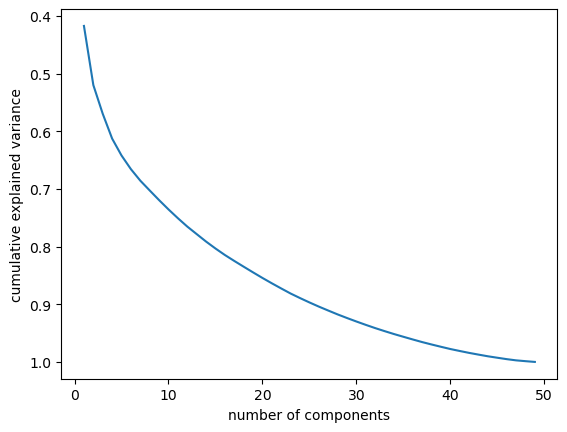

In [12]:
x = list(range(1, 1 + len(pca4.explained_variance_ratio_)))
plt.plot(x, np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.gca().invert_yaxis()
plt.show()

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (867, 49)
Reduced shape: (867, 10)


In [16]:
pca.explained_variance_ratio_

array([0.41737636, 0.10259865, 0.04976014, 0.04300923, 0.02932233,
       0.0236971 , 0.01992822, 0.0168838 , 0.01673028, 0.01600077])

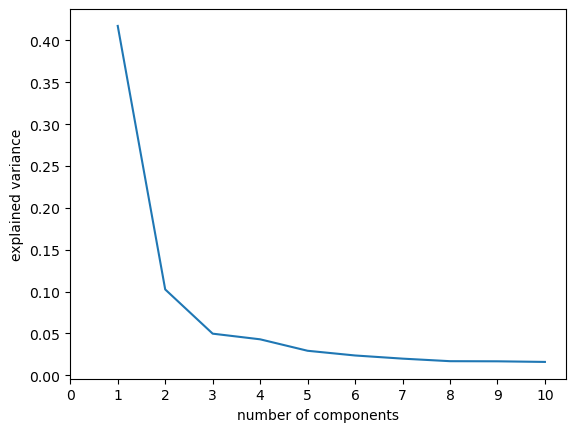

In [19]:
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

In [22]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components = 2)
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
print("PCA component shape: {}".format(pca.components_.shape))

Original shape: (867, 49)
Reduced shape: (867, 2)
PCA component shape: (2, 49)


Text(0, 0.5, 'Principal components')

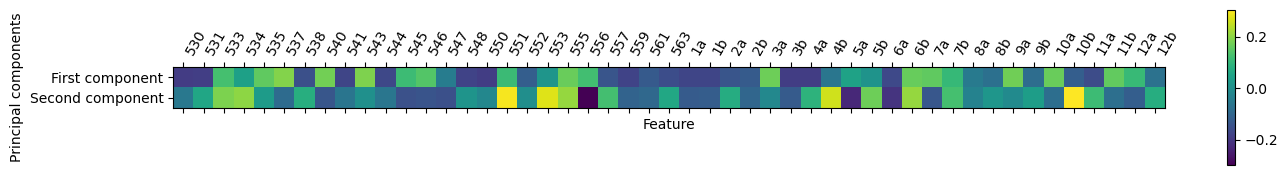

In [31]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(questions_data.columns)),
           questions_data.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

In [22]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming you have already fit your PCA model
pca = PCA(n_components=10)
pca.fit(questions_data)

# Get the index of the feature with the highest variance
max_variance_index = pca.explained_variance_ratio_.argmax()

# Get the components of PCA
components = pca.components_

# Get the features that cause the largest variance
features_with_max_variance = components[max_variance_index]

# Assuming your original feature names are in a list called 'original_features'
original_features = questions_data.columns.tolist()

# Get the names of the features
names_of_features_with_max_variance = [original_features[i] for i in range(len(original_features)) if features_with_max_variance[i] != 0]

print("Features causing the largest variance:", names_of_features_with_max_variance)


Features causing the largest variance: ['530', '531', '533', '534', '535', '537', '538', '540', '541', '543', '544', '545', '546', '547', '548', '550', '551', '552', '553', '555', '556', '557', '559', '561', '563', '1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a', '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b']


t-sne

In [33]:
# Load the data
allData = pd.read_excel('alldata.xlsx')

# Define columns to drop
columns_to_drop = ['storkreds', 'alder', 'navn']

# Drop specified columns
questions_party = allData.drop(columns=columns_to_drop)
questions_party.columns

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'parti', '1a', '1b', '2a', '2b',
       '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a', '8b',
       '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b'],
      dtype='object')

In [36]:
#convert parti names to numbers
questions_Noparty = questions_party.drop(columns='parti')

49


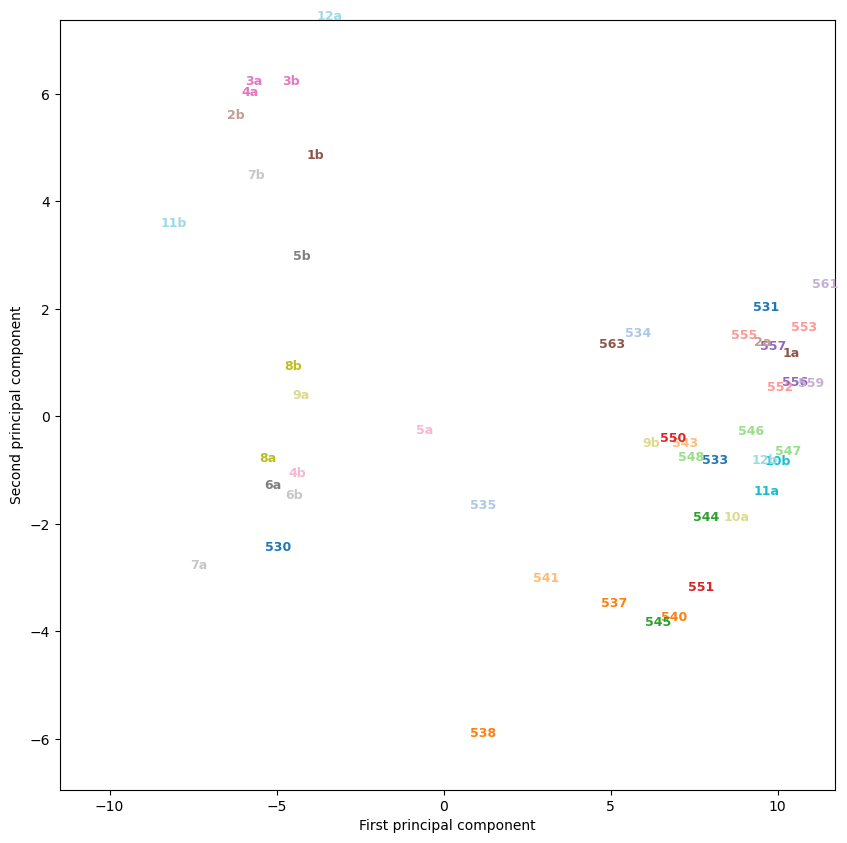

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
pca.fit(questions_Noparty)
# transform the data onto the first two principal components
questions_party_pca = pca.transform(questions_Noparty)
length = len(questions_Noparty.columns)
print(length)
colors = plt.cm.tab20(np.linspace(0, 1, length))  # Fix the indexing issue here
plt.figure(figsize=(10, 10))
plt.xlim(questions_party_pca[:, 0].min(), questions_party_pca[:, 0].max())
plt.ylim(questions_party_pca[:, 1].min(), questions_party_pca[:, 1].max())
for i, col_name in enumerate(questions_Noparty.columns):
     # actually plot the data as text instead of using scatter
    plt.text(questions_party_pca[i, 0], questions_party_pca[i, 1], col_name,
             color=colors[i % length],  # Use modulo operator to loop colors
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()


In [56]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity= 30, random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
questions_tSNE = tsne.fit_transform(questions_Noparty)

Length of questions_Noparty.columns: 49
Length of questions_tSNE: 867


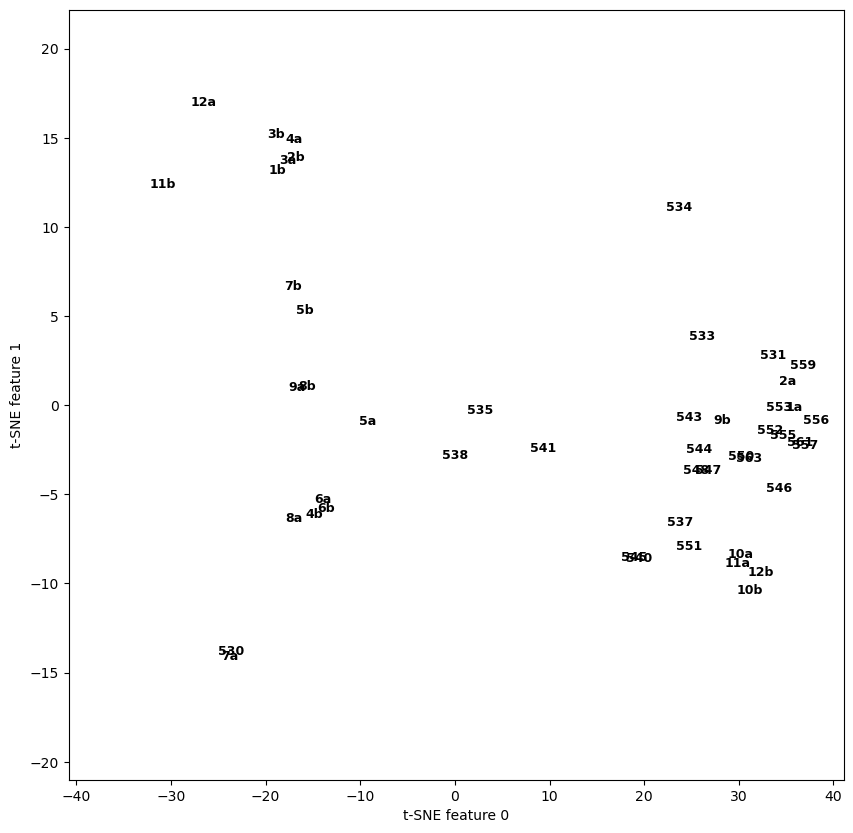

In [70]:
import matplotlib.pyplot as plt

# Check the shape of questions_tSNE
print("Length of questions_Noparty.columns:", len(questions_Noparty.columns))
print("Length of questions_tSNE:", len(questions_tSNE))

plt.figure(figsize=(10, 10))
plt.xlim(questions_tSNE[:, 0].min(), questions_tSNE[:, 0].max() + 1)
plt.ylim(questions_tSNE[:, 1].min(), questions_tSNE[:, 1].max() + 1)

for i in range(len(questions_Noparty.columns)):  # Use the length of questions_tSNE
    # actually plot the column names as text instead of using scatter
    plt.text(questions_tSNE[i, 0], questions_tSNE[i, 1], str(questions_Noparty.columns[i]),
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()


note: small differences can be visible in both the size and perhaps the placement since pca shapes the dataset and t-sne preserves the original shape